In [356]:
import torch
import torchaudio
import auraloss
import resampy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pesq import pesq

In [318]:
class PESQ(torch.nn.Module):
    def __init__(self, sample_rate):
        super().__init__()
        self.sample_rate = sample_rate

    def forward(self, inp, tgt):
        if self.sample_rate != 16000:
            tgt = resampy.resample(
                tgt.view(-1).numpy(),
                self.sample_rate,
                16000,
            )
            inp = resampy.resample(
                inp.view(-1).numpy(),
                self.sample_rate,
                16000,
            )

        return pesq(
            16000,
            tgt,
            inp,
            'wb',
        )

In [319]:
mrstft =  auraloss.freq.MultiResolutionSTFTLoss(
                fft_sizes=[32, 128, 512, 2048, 8192, 32768],
                hop_sizes=[16, 64, 256, 1024, 4096, 16384],
                win_lengths=[32, 128, 512, 2048, 8192, 32768],
                w_sc=0.0,
                w_phs=0.0,
                w_lin_mag=1.0,
                w_log_mag=1.0,
            )

In [320]:
p_metric = PESQ(24_000)

In [321]:
def get_average_spectrum(x):
    X = torch.stft(x, 4096, return_complex=True, normalized=True)
    X = X.abs()  # convert to magnitude
    X = X.mean(dim=-1).view(-1)  # average across frames
    return X

In [322]:
def smooth_spectrum(H):
    # apply Savgol filter for smoothed target curve
    return scipy.signal.savgol_filter(H, 1025, 2)

In [323]:
sns.set(style='white')

In [324]:
DATA_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/style_matching"

In [325]:
FIG_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/figures/spectrogram_comparison"

In [326]:
effects = [
    'ambience', 
    'combo', 
    'delay', 
    'multiband', 
    'overdrive', 
    'ringmod'
]

In [327]:
files = [
    'x.wav', 
    'y_ref.wav', 
    'y.wav', 
    'y_hat.wav'
]

In [328]:
file_name_map = {
    'x.wav': 'Input',
    'y_ref.wav': 'Target',
    'y.wav': '$y$',
    'y_hat.wav': '$\hat{y}$'
}

In [329]:
fx_name_map = {
    'ambience': 'Ambience',
    'combo': 'Combo',
    'multiband': 'MultiBand',
    'overdrive': 'Overdrive',
    'ringmod': 'RingMod',
    'delay': 'Delay'
}

In [335]:
metrics = {}

for i, fx in enumerate(effects):
    y_audio, _ = torchaudio.load(f"{DATA_DIR}/{fx}/y.wav")
    y_hat_audio, _ = torchaudio.load(f"{DATA_DIR}/{fx}/y_hat.wav")

    
    metrics[fx] = {'mrstft': mrstft(y_audio, y_hat_audio).item(), 'pesq': p_metric(y_audio, y_hat_audio)}

In [336]:
metrics

{'ambience': {'mrstft': 0.7763574123382568, 'pesq': 2.591082811355591},
 'combo': {'mrstft': 0.5182053446769714, 'pesq': 4.35514497756958},
 'delay': {'mrstft': 2.279348373413086, 'pesq': 1.1808503866195679},
 'multiband': {'mrstft': 0.6919329762458801, 'pesq': 4.393110752105713},
 'overdrive': {'mrstft': 0.15159066021442413, 'pesq': 4.6058030128479},
 'ringmod': {'mrstft': 1.803108811378479, 'pesq': 1.0579971075057983}}

In [360]:
metrics_df = pd.DataFrame(metrics).transpose()

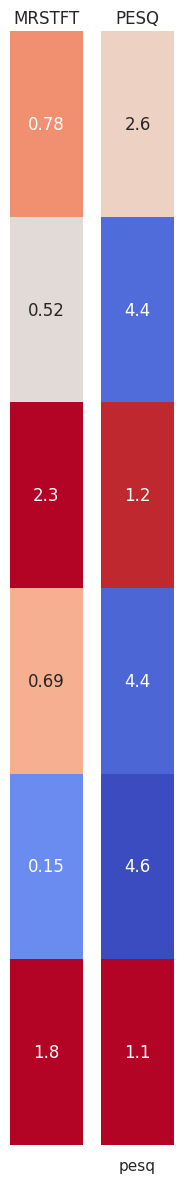

In [412]:
fig, ax = plt.subplots(1,2, figsize=(2, 12))

sns.heatmap(metrics_df[['mrstft']], annot=True, ax = ax[0], cmap='coolwarm', cbar=False, vmin=0, vmax=1)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_title("MRSTFT")

sns.heatmap(metrics_df[['pesq']], annot=True, ax = ax[1], cmap='coolwarm_r', cbar=False)
ax[1].set_yticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_title("PESQ")
# plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

plt.tight_layout()
plt.show()

In [420]:
metrics_df[['mrstft']].iloc[0].values.reshape(-1,1)

array([[0.77635741]])

<AxesSubplot: >

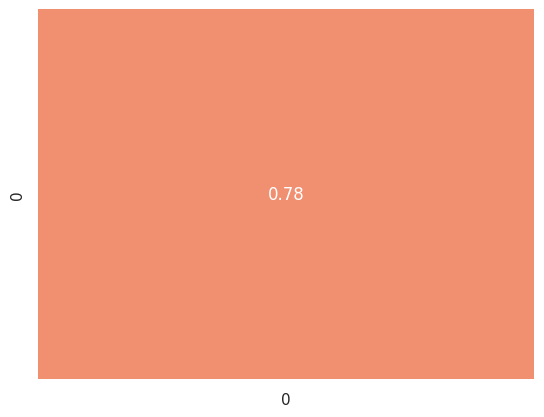

In [430]:
sns.heatmap(metrics_df[['mrstft']].loc['ambience'].values.reshape(-1,1), annot=True, cmap='coolwarm', cbar=False, vmin=0, vmax=1)

In [434]:
def get_metrics_value(df, effect, metric):
    return df[[metric]].loc[effect].values.reshape(-1, 1)

In [ ]:
mrstft_min = 

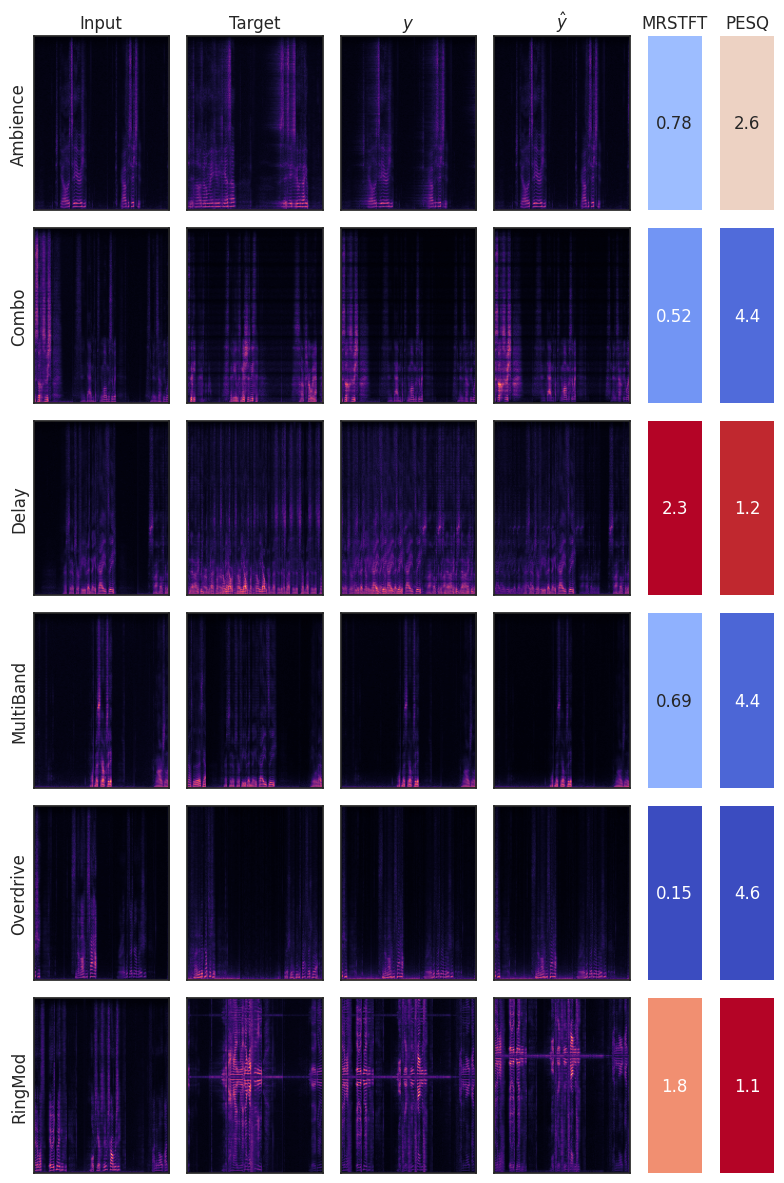

In [441]:
fig, ax = plt.subplots(len(effects), 
                       len(files) + 2, 
                       figsize=(10, 12),  
                       gridspec_kw={'width_ratios': [1]*len(files)+[0.4,0.4]})

for i, fx in enumerate(effects):
    for j in range(6):
        if j <= 3:
            file = files[j]
            audio, _ = torchaudio.load(f"{DATA_DIR}/{fx}/{file}")
            X = get_spectrogram(audio)
            ax[i,j].imshow(X, aspect='auto', cmap='magma')
            
            if i == 0:
                ax[i,j].set_title(file_name_map[file])
        else:
            metric = 'pesq' if j==5 else 'mrstft'
            cmap = 'coolwarm_r' if metric == 'pesq' else 'coolwarm'
            val = get_metrics_value(metrics_df, fx, metric)
            
            vmin = metrics_df[metric].min()
            vmax = metrics_df[metric].max()
            
            sns.heatmap(val, annot=True, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax, ax = ax[i,j])
            
            if i == 0:
                ax[i,j].set_title(metric.upper())
            
        ax[i,j].grid(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
            
        if j == 0:
            ax[i,j].set_ylabel(fx_name_map[fx])
            
    
plt.tight_layout()
    
plt.savefig(f"{FIG_DIR}/{len(effects)}dafx.pdf")